In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [3]:
import sys
sys.path.append('../')

In [4]:
import scipy.stats as sts
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

### Canary

In [8]:
%%time
#canary_p = '../../../data/CANARY/CANARY/CANARY202104'
pmpm_p = '../../../temp/PMPM.p'
#preg_p = '../../../data/pregnancies'

#preg = pq.read_table(preg_p).to_pandas()
#canary = pq.read_table(canary_p).to_pandas()
pmpm = pd.read_pickle(pmpm_p)




CPU times: user 2.55 s, sys: 1.33 s, total: 3.88 s
Wall time: 3.88 s


### CCM

In [5]:
%%time
pmpm_ccm_path = '../../../temp/pmpm_ccm.csv'
ref_ccm_path = '../../../temp/ref.csv'


pmpm_ccm = pd.read_csv(pmpm_ccm_path)
ref_ccm = pd.read_csv(ref_ccm_path)


CPU times: user 1min 47s, sys: 13.2 s, total: 2min
Wall time: 2min


In [6]:
!rm -r ../../../temp/pmpm_post18_cmm.csv
!rm -r ../../../temp/pmpm_ccm.csv
!rm -r ../../../temp/ref.csv
!rm  -r ../../../temp/PMPM.p

rm: cannot remove ‘../../../temp/pmpm_post18_cmm.csv’: No such file or directory
rm: cannot remove ‘../../../temp/pmpm_ccm.csv’: No such file or directory
rm: cannot remove ‘../../../temp/ref.csv’: No such file or directory


In [7]:
pmpm_ccm.head()

,PERS_ID,MEMBER_ID,MYR,MBR_GNDR,AGE_AT_MIDMONTH,ALLOW_AMT,ALLOW_IP,ALLOW_SNF,ALLOW_OP,ALLOW_ER,ALLOW_RD,ALLOW_LAB,ALLOW_PATH,ALLOW_RX,ALLOW_UC,ALLOW_PCP,ALLOW_SPEC,ALLOW_OVMHSA,ALLOW_HHDM,DAYS_IP,DAYS_SNF,CC_HYPOTHYROID,CC_AMI,CC_ALZHEIMER,CC_ALZHEIMER_PLUS,CC_ANEMIA,CC_ASTHMA,CC_ATRIAL_FIB,CC_BPH,CC_CATARACT,CC_COPD,CC_DEPRESSION,CC_GLAUCOMA,CC_HIP_FRACTURE,CC_HYPERLIPIDEMIA,CC_HYPERTENSION,CC_OSTEOPOROSIS,CC_STROKE,CC_BREAST_CANCER,CC_COLORECTAL_CANCER,CC_PROSTATE_CANCER,CC_LUNG_CANCER,CC_ENDOMETRIAL_CANCER,CC_CHRONIC_KIDNEY,CC_DIABETES,CC_HEART_FAILURE,CC_ISCHEMIC,CC_ARTHRITIS,CC_AUTISM,CC_CEREBRAL_PALSY,CC_CYSTIC_FIBROSIS,CC_EPILEPSY,CC_INT_DISAB,CC_LEARN_DISAB,CC_MOBILITY_IMPAIR,CC_MULTIPLE_SCLEROSIS,CC_MUSCULAR_DYSTROPHY,CC_DEVELOP_DELAYS,CC_HEARING_IMPAIR,CC_VISUAL_IMPAIR,CC_SPINA_BIFIDA,CC_SPINAL_CORD,CC_TRAUMATIC_BRAIN,CC_ADHD,CC_ANXIETY_DISORDER,CC_BIPOLAR,CC_DEPRESSIVE_DISORDERS,CC_FIBROMYALGIA,CC_LEUKEMIAS,CC_LIVER,CC_MIGRAINE,CC_OBESITY,CC_PERIPHERAL,CC_PERSONALITY,CC_PTSD,CC_PRESSURE,CC_SCHIZOPHRENIA,CC_SCHIZOPHRENIA_OTHER,CC_TOBACCO,CC_HEPATITIS_GEN,CC_HEPATITIS_A,CC_HEPATITIS_B_ACUTE,CC_HEPATITIS_B_CHRONIC,CC_HEPATITIS_C_ACUTE,CC_HEPATITIS_C_CHRONIC,CC_HEPATITIS_C_UNSPECIFIED,CC_HEPATITIS_D,CC_HEPATITIS_E,CC_DX_CNT,CC_DISAB_DX_CNT
0,2612620,CD124177500,201510,M,75.70,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2613447,6A970852800,201510,M,75.54,2159.51,0.0,0.0,0.0,0.0,44.3,91.05,0.0,990.17,238.75,0.0,421.37,0.0,45.0,0.0,0.0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0
2,2613818,CD124453801,201510,M,75.46,176.44,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,176.44,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0
3,2740429,5G934204100,201510,M,61.04,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2736648,5H997051300,201510,M,61.35,213.43,0.0,0.0,0.0,0.0,0.0,3.06,0.0,0.00,0.00,0.0,142.97,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [10]:
pmpm_ccm.columns = [col.upper() for col in pmpm_ccm.columns]
pmpm_ccm.rename(columns = {'PERSON_ID':'PERS_ID'}, inplace = True)
cols = [col for col in pmpm.columns if  col != 'MEDICAID_LOB']
pmpm_ccm = pmpm_ccm[cols]

In [11]:
pmpm_ccm.head()

,PERS_ID,MYR,MBR_GNDR,AGE_AT_MIDMONTH,ALLOW_AMT,ALLOW_ER,ALLOW_IP,CC_ADHD,CC_ALZHEIMER,CC_ALZHEIMER_PLUS,CC_AMI,CC_ANEMIA,CC_ANXIETY_DISORDER,CC_ARTHRITIS,CC_ASTHMA,CC_ATRIAL_FIB,CC_AUTISM,CC_BIPOLAR,CC_BPH,CC_BREAST_CANCER,CC_CATARACT,CC_CEREBRAL_PALSY,CC_CHRONIC_KIDNEY,CC_COLORECTAL_CANCER,CC_COPD,CC_CYSTIC_FIBROSIS,CC_DEPRESSION,CC_DEPRESSIVE_DISORDERS,CC_DEVELOP_DELAYS,CC_DIABETES,CC_DISAB_DX_CNT,CC_DX_CNT,CC_ENDOMETRIAL_CANCER,CC_EPILEPSY,CC_FIBROMYALGIA,CC_GLAUCOMA,CC_HEARING_IMPAIR,CC_HEART_FAILURE,CC_HEPATITIS_A,CC_HEPATITIS_B_ACUTE,CC_HEPATITIS_B_CHRONIC,CC_HEPATITIS_C_ACUTE,CC_HEPATITIS_C_CHRONIC,CC_HEPATITIS_C_UNSPECIFIED,CC_HEPATITIS_D,CC_HEPATITIS_E,CC_HEPATITIS_GEN,CC_HIP_FRACTURE,CC_HYPERLIPIDEMIA,CC_HYPERTENSION,CC_HYPOTHYROID,CC_INT_DISAB,CC_ISCHEMIC,CC_LEARN_DISAB,CC_LEUKEMIAS,CC_LIVER,CC_LUNG_CANCER,CC_MIGRAINE,CC_MOBILITY_IMPAIR,CC_MULTIPLE_SCLEROSIS,CC_MUSCULAR_DYSTROPHY,CC_OBESITY,CC_OSTEOPOROSIS,CC_PERIPHERAL,CC_PERSONALITY,CC_PRESSURE,CC_PROSTATE_CANCER,CC_PTSD,CC_SCHIZOPHRENIA,CC_SCHIZOPHRENIA_OTHER,CC_SPINAL_CORD,CC_SPINA_BIFIDA,CC_STROKE,CC_TOBACCO,CC_TRAUMATIC_BRAIN,CC_VISUAL_IMPAIR
0,2612620,201510,M,75.70,0.00,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2613447,201510,M,75.54,2159.51,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,7,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2613818,201510,M,75.46,176.44,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2740429,201510,M,61.04,0.00,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2736648,201510,M,61.35,213.43,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
ref_ccm.head()

,person_id,ref_id,ref_create_date,referral_date,comanaged,principal_reason,reason_other,referral_urgent,source_external,source_external_other,source_internal,source_internal_other,case_id,case_type,close_date,close_note,close_outcome
0,3845310,1033826,2014-01-02,2014-01-02,NaN,Behavioral Health Other (Specify under Additio...,BH ER campaign.,Yes,NaN,NaN,Behavioral Health,NaN,NaN,NaN,NaN,NaN,NaN
1,2892798,1034270,2014-01-02,2014-01-02,No,Transplants (solid organ and bone marrow),Voice mail message from S,No,NaN,NaN,Health Ally HRA,NaN,168824.0,MedCM Complex,2014-08-19,case status changed,unable to contact
2,2952872,1045626,2014-01-03,2014-01-03,No,Other: please specify,mbr s/p surgery w/complic,Yes,EPC Provider,NaN,NaN,NaN,168697.0,MedCM Episodic,2014-09-16,case status changed,goals met
3,3955779,1048066,2014-01-06,2014-01-06,No,NaN,NaN,No,NaN,NaN,Inpatient Programs,NaN,NaN,NaN,NaN,NaN,NaN
4,2777597,1049002,2014-01-06,2014-01-06,NaN,Multiple co-morbid or complex conditions: incl...,NaN,Yes,EPC Provider,NaN,NaN,NaN,168821.0,MedCM Episodic,2014-05-14,case status changed,goals met


In [16]:
ref_ccm.principal_reason.value_counts()

Other: please specify                                                                     19280
Behavioral Health Other (Specify under Additional Information)                            14871
Coordination of Care                                                                      11404
High Risk Pregnancy                                                                        7805
Diabetes                                                                                   4611
Mental Health Condition (Specify under Additional Information)                             3005
Substance Use Condition (Specify under Additional Information)                             2459
Oncology                                                                                   1697
Psychosocial Concerns                                                                      1603
COPD                                                                                       1341
Multiple co-morbid or complex conditions

In [18]:
pmpm_ccm.MYR = pmpm_ccm.MYR.astype(int)
pmpm_ccm.PERS_ID = pmpm_ccm.PERS_ID.astype(str)
pmpm_ccm.AGE_AT_MIDMONTH = pmpm_ccm.AGE_AT_MIDMONTH.astype(int)
pmpm_ccm.ALLOW_AMT = pmpm_ccm.ALLOW_AMT.astype(int)

In [19]:
pmpm_ccm = pmpm_ccm.drop_duplicates(subset = ['PERS_ID', 'MYR']).reset_index(drop = True)

In [20]:
pmpm_ccm.shape, ref_ccm.shape

In [21]:
ref_ccm = ref_ccm[~ref_ccm.ref_create_date.isin(['Member (Self Referral)'])].reset_index(drop = True)
ref_ccm['REGISTER_DATE'] = pd.to_datetime(ref_ccm['ref_create_date'], format = '%Y-%m-%d')
ref_ccm.rename(columns = {'person_id':'PERS_ID'}, inplace = True)
ref_ccm.sort_values(by = ['PERS_ID', 'REGISTER_DATE'], inplace = True)
ref_ccm.dropna(axis = 0, subset = ['PERS_ID', 'REGISTER_DATE'], inplace = True)
ref_ccm2 = ref_ccm.groupby(by = 'PERS_ID').apply(lambda x: x.iloc[0]).reset_index(drop = True)

In [22]:
ref_ccm2

,PERS_ID,ref_id,ref_create_date,referral_date,comanaged,principal_reason,reason_other,referral_urgent,source_external,source_external_other,source_internal,source_internal_other,case_id,case_type,close_date,close_note,close_outcome,REGISTER_DATE
0,2563091,1471103,2014-02-12,2014-02-12,NaN,Other: please specify,see progress notes,No,NaN,NaN,AMCH Readmission Avoidance,NaN,44500.0,MedCM Episodic,2014-02-13,case status changed,other,2014-02-12
1,2563337,2243272,2015-02-17,2015-02-17,NaN,Heart Failure,99y mbr discharged from a,NaN,NaN,NaN,Inpatient Programs,NaN,401029.0,MedCM Episodic,2015-03-27,case status changed,goals met,2015-02-17
2,2563702,1929457,2014-10-22,2014-10-22,No,Other: please specify,see care web eps-00121560,No,NaN,NaN,Inpatient Programs,NaN,375357.0,MedCM Episodic,2014-11-17,case status changed,goals met,2014-10-22
3,2563879,2034588,2014-12-16,2014-12-16,No,Coordination of Care,NaN,Yes,NaN,NaN,Medical Case Management,Matrix assessment,388160.0,MedCM Episodic,2015-01-27,case status changed,other,2014-12-16
4,2563967,5519512,2019-11-21,2019-11-21,NaN,Other: please specify,NaN,No,Member Family/Caregiver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42045,5039937,5851916,2020-06-23,2020-06-16,NaN,NaN,NaN,NaN,NaN,NaN,Inpatient Programs,NaN,NaN,NaN,NaN,NaN,NaN,2020-06-23
42046,5040810,5876404,2020-07-13,2020-07-13,NaN,Substance Use Condition (Specify under Additio...,NaN,Yes,NaN,NaN,Behavioral Health,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-13
42047,5041042,5878274,2020-07-14,2020-07-14,No,Mental Health Condition (Specify under Additio...,NaN,No,NaN,NaN,Behavioral Health,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-14
42048,5041108,5869376,2020-07-07,2020-07-07,NaN,Other: please specify,John is new to Medicaid.,No,NaN,NaN,Medical Case Management,NaN,NaN,NaN,NaN,NaN,NaN,2020-07-07


In [12]:
pmpm_ccm.to_pickle('../../../temp/pmpm_ccm.p')
ref_ccm.to_pickle('../../../temp/ref_ccm.p')

## KMF Curves Survival

In [23]:
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time

In [35]:
#select columns from ref
ref_ccm_select = ref_ccm2[['PERS_ID', 'REGISTER_DATE', 'principal_reason']]

In [45]:
#convert register date to MYR
ref_ccm_select['REGISTER_DATE'] = ref_ccm_select['REGISTER_DATE'].dt.strftime('%Y%m').astype('int')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [51]:
#join these two tables on person id
merged = pmpm_ccm.join(ref_ccm_select.set_index('PERS_ID'), on='PERS_ID', how='inner')

In [54]:
#sort values and rearrange columns
merged = merged.sort_values(by=['PERS_ID', 'MYR', 'REGISTER_DATE'])[['PERS_ID', 'MYR', 'REGISTER_DATE', 'principal_reason', 'ALLOW_IP', 'ALLOW_ER']]

In [65]:
#create acute care binary event
merged['ACUTE_BIN'] = ((merged.ALLOW_IP>0) | (merged.ALLOW_ER>0)).astype(int)

In [115]:
#check how many samples in pmpm are after their referral date
(merged['MYR']>=merged['REGISTER_DATE']).astype(int).sum()

1086528

In [117]:
#only rows where data is equal or later than register date for referral
merged = merged[merged.MYR>=merged.REGISTER_DATE]

In [85]:
from datetime import datetime

#change the date formats to datetimes for calculating difference in month
merged['reg'] = merged.REGISTER_DATE.astype('str').apply(lambda x: datetime.strptime(x, '%Y%m'))
merged['myr'] = merged.MYR.astype('str').apply(lambda x: datetime.strptime(x, '%Y%m'))

In [119]:
#difference between pmpm record date and first ref date (in months)
merged['duration'] = np.round(((merged['myr'] - merged['reg'])/np.timedelta64(1, 'M'))).astype(int)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [155]:
#drop nans in reason code
merged.dropna(axis = 0, subset = ['PERS_ID', 'REGISTER_DATE', 'principal_reason'], inplace = True)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [173]:
#convert the reason codes into list
reason_codes = (merged.principal_reason.value_counts()).index.values.tolist()

In [199]:
window considered for survival curves
merged = merged[(merged.MYR>=201701) & (merged.MYR<=202006)]

In [205]:
merged.duration.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 10, 11, 12, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,  8,  9,
       13, 69, 70, 71, 72, 73, 74, 75, 76, 77])

## Survival Curves

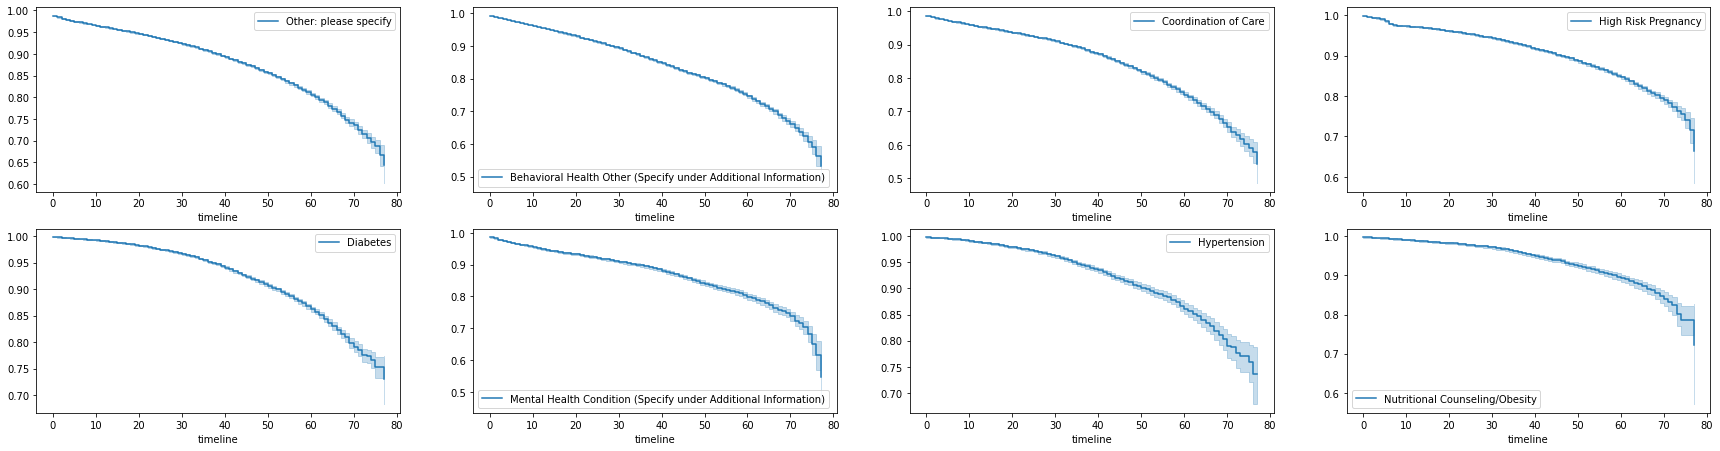

In [201]:
from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (30,40)

for i, reason in enumerate(reason_codes[:8]):
    ax = plt.subplot(10, 4, i+1)
    
    kmf = KaplanMeierFitter()
    df = merged[merged.principal_reason==reason]
    
    T = df['duration']
    E = df['ACUTE_BIN']
    
    kmf.fit(T, event_observed=E, label=reason)
    kmf.plot_survival_function(ax=ax, legend=True)

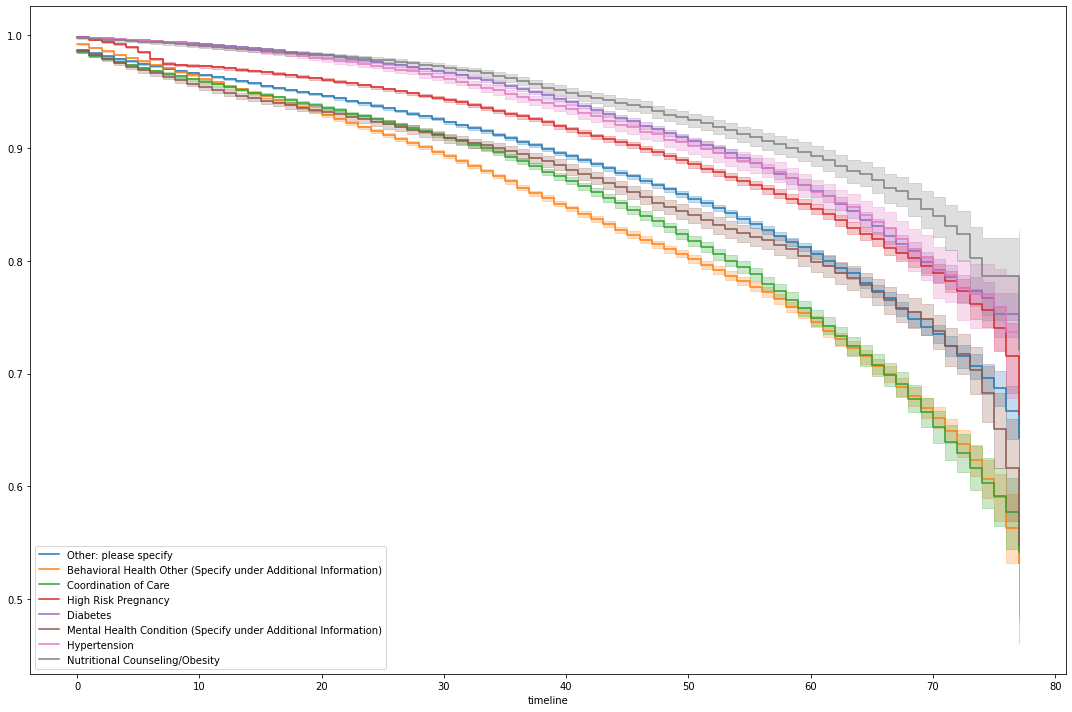

In [208]:
from lifelines import KaplanMeierFitter
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

#top 8 most frequent reason codes' population survival curve after first referral: time to first acute care visit

for i, reason in enumerate(reason_codes[:8]):
    
    kmf = KaplanMeierFitter()
    df = merged[merged.principal_reason==reason]
    
    T = df['duration']
    E = df['ACUTE_BIN']
    
    kmf.fit(T, event_observed=E, label=reason)
    kmf.plot_survival_function()
    plt.tight_layout()

<AxesSubplot:xlabel='timeline'>

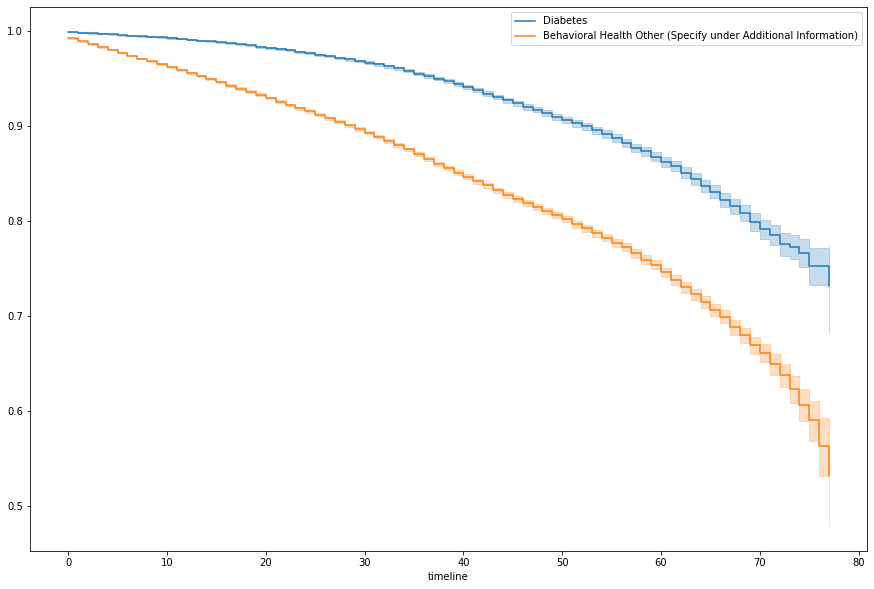

In [203]:
#two reason codes particular to compare

kmf = KaplanMeierFitter()
df = merged[merged.principal_reason=='Diabetes']
df2 = merged[merged.principal_reason=='Behavioral Health Other (Specify under Additional Information)']

T = df['duration']
T2 = df2['duration']
E = df['ACUTE_BIN']
E2 = df2['ACUTE_BIN']

kmf.fit(T, event_observed=E, label='Diabetes')
kmf.plot_survival_function()
kmf.fit(T2, event_observed=E2, label='Behavioral Health Other (Specify under Additional Information)')
kmf.plot_survival_function()

In [207]:
#logrank statistics
from lifelines.statistics import logrank_test

results = logrank_test(T, T2, E, E2, alpha=.05)

results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.05
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        3297.44 <0.005       inf